In [ ]:
!pip install -q -U tensorflow-addons umap-learn

     |████████████████████████████████| 686kB 4.0MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 1.2MB 52.6MB/s 


In [49]:
import random
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

np.random.seed(2018)
np.random.RandomState(2018)
random.seed(2018)

from tensorflow.keras.preprocessing.image import load_img, img_to_array
  
from skimage.filters import try_all_threshold, threshold_otsu

import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import umap

from tensorflow.keras.applications import resnet, EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras import Model

import random
import tensorflow as tf
from tqdm.notebook import tqdm

from tensorflow.keras.datasets import mnist
 
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.utils import model_to_dot

from IPython.display import SVG
from matplotlib import pyplot as plt
import math
import plotly.express as px
from sklearn.model_selection import train_test_split

np.random.seed(37)

In [ ]:
def save_numpy(arr, file_path):
  with open(file_path, 'wb') as f:
    np.save(f, arr)

def load_numpy(file_path):  
  with open(file_path, 'rb') as f:
      return np.load(f) 

In [ ]:
data_base_path = "drive/MyDrive/mlexperiments/data/cedar"
img_base_path = data_base_path
forg_list = os.listdir(data_base_path + "/full_forg")
orig_list = os.listdir(data_base_path + "/full_org")
forg_list.sort()
len(forg_list)
forg_list.remove("Thumbs.db")
orig_list.remove("Thumbs.db")
forg_list[:2], orig_list[:2]

(['forgeries_10_1.png', 'forgeries_10_10.png'],
 ['original_14_19.png', 'original_14_18.png'])

 ## Structuring as Classification Task

- Each original signer is an individual class. 55 signers each with 24 examples.
- Each forgery is an individual class. 55 forgeries, each with 24 examples.
- 110 example classes total

In [ ]:
img_target_size = (224, 224)

def threshold_image(img):
  thresh = threshold_otsu(img)
  return img > thresh

def get_data_np():
  orig_holder = []
  label_holder = []
  data_holder = []

  for i in tqdm(range(1,56)):
    for j in range(1,25): 
      img_path = data_base_path + "/full_org/original_" + str(i) + "_" + str(j) + ".png" 
      img_np = load_img(img_path, target_size=img_target_size )
      img_np = np.squeeze(img_to_array(img_np)) 
      img_np = resnet.preprocess_input(img_np)
      img_np = threshold_image(img_np) 
       
      data_holder.append(img_np )
      label_holder.append(i)
  for i in tqdm(range(1,56)):
    for j in range(1,25): 
      img_path = data_base_path + "/full_forg/forgeries_" + str(i) + "_" + str(j) + ".png" 
      img_np = load_img(img_path, target_size=img_target_size )
      img_np = np.squeeze(img_to_array(img_np)) 
      img_np = threshold_image(img_np)
      img_np = resnet.preprocess_input(img_np)
       
      data_holder.append(img_np )
      label_holder.append(i+55)

  return np.array(data_holder), np.array(label_holder)

def generate_data():
  X, y = get_data_np()
  save_numpy(X, data_base_path+"/numpy/x.npy")
  save_numpy(y, data_base_path+"/numpy/y.npy")


def plot_features(test_features, y, title="UMAP Embedding Projection", metric="euclidean"): 
  print("Compute UMAP for vector with shape", test_features.shape, " metric:", metric)
  reducer = umap.UMAP(n_neighbors=15, n_components=2, metric=metric)
  embedding = reducer.fit_transform(test_features)

  colors = [ str(x) for x in y] 
  acm = [x for x in colors]

  fig = px.scatter(
      x=embedding[:, 0],
      y=embedding[:, 1],
      color=acm,
      opacity=0.5,
      hover_name=acm,
      symbol=acm,
      width=1200,
      height=900,
      title=title,
  )
  fig.show()  

def plot_history(history, title=""): 
   
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Losss | ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  
  plt.show()

In [ ]:
X = load_numpy(data_base_path+"/numpy/x.npy") 
y = load_numpy(data_base_path+"/numpy/y.npy") 
X.shape, y.shape

((2640, 224, 224, 3), (2640,))

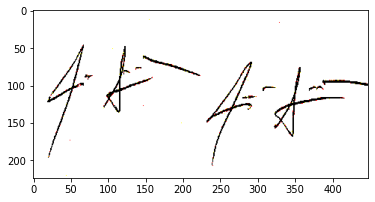

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
plt.imshow(np.concatenate((X[0],X[2]), axis=1));

In [ ]:
input_shape =(224,224,3)
def get_resnet(input_shape):
  base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=input_shape, include_top=False
  )

  flatten = layers.Flatten()(base_cnn.output)
  dense1 = layers.Dense(512, activation="relu")(flatten)
  dense1 = layers.BatchNormalization()(dense1)
  dense2 = layers.Dense(256, activation="relu")(dense1)
  dense2 = layers.BatchNormalization()(dense2)
  output = layers.Dense(256)(dense1)
  output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings

  embedding = Model(base_cnn.input, output, name="Embedding")

  # trainable = False
  # for layer in base_cnn.layers:
  #     if layer.name == "conv5_block1_out":
  #         trainable = True
  #     layer.trainable = trainable 
  return embedding   

input_shape =(224,224,3)
def get_effB0(input_shape):
  base_cnn = EfficientNetB0. resnet.ResNet50(
    weights="imagenet", input_shape=input_shape, include_top=False
  )

  flatten = layers.Flatten()(base_cnn.output)
  dense1 = layers.Dense(512, activation="relu")(flatten)
  dense1 = layers.BatchNormalization()(dense1)
  dense2 = layers.Dense(256, activation="relu")(dense1)
  dense2 = layers.BatchNormalization()(dense2)
  output = layers.Dense(256)(dense1)
  output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings

  embedding = Model(base_cnn.input, output, name="Embedding")

  # trainable = False
  # for layer in base_cnn.layers:
  #     if layer.name == "conv5_block1_out":
  #         trainable = True
  #     layer.trainable = trainable 
  return embedding  


In [ ]:
# Compile the model
# warning .. without setting batch size to something reasonable like 64, 
# training loss degrades to nan .. oops!
num_epochs = 80
batch_size = 64


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.80,
    staircase=False)

triplet_model = get_resnet(input_shape)
triplet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),  
    loss=tfa.losses.TripletSemiHardLoss())

In [ ]:
# Train the network
triplet_history = triplet_model.fit(
    X_train, y_train, 
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    epochs=num_epochs)

Epoch 1/80
33/33 [==============================] - 17s 368ms/step - loss: 0.9128 - val_loss: 0.9928
Epoch 2/80
33/33 [==============================] - 11s 342ms/step - loss: 0.8195 - val_loss: 0.9930
Epoch 3/80
33/33 [==============================] - 11s 342ms/step - loss: 0.7282 - val_loss: 0.9940
Epoch 4/80
33/33 [==============================] - 11s 342ms/step - loss: 0.6621 - val_loss: 0.9863
Epoch 5/80
33/33 [==============================] - 11s 342ms/step - loss: 0.5838 - val_loss: 0.9399
Epoch 6/80
33/33 [==============================] - 11s 342ms/step - loss: 0.5255 - val_loss: 0.8154
Epoch 7/80
33/33 [==============================] - 11s 342ms/step - loss: 0.5690 - val_loss: 0.7495
Epoch 8/80
33/33 [==============================] - 11s 342ms/step - loss: 0.5200 - val_loss: 0.7074
Epoch 9/80
33/33 [==============================] - 11s 341ms/step - loss: 0.5480 - val_loss: 0.6859
Epoch 10/80
33/33 [==============================] - 11s 342ms/step - loss: 0.5005 - val_lo

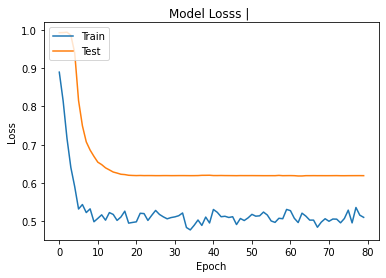

In [ ]:
plot_history(triplet_history)
test_features = triplet_model(X_test)

In [ ]:
model_basepath = "drive/MyDrive/mlexperiments/siamese/"

def save_model(name, model):
  print(">>> Saving model", name) 
  model.save("models/" + name)  
  !cp -r models $model_basepath 
 
save_model("cedar_triplet", triplet_model) 

>>> Saving model cedar_triplet
INFO:tensorflow:Assets written to: models/cedar_triplet/assets


In [ ]:
test_features = triplet_model(X_test)
plot_features(test_features, y_test, title="UMAP Embedding Projection  Triplet" , metric="cosine" )

Compute UMAP for vector with shape (528, 256)  metric: cosine


In [47]:
import tensorflow

In [48]:
cedar_model =  tensorflow.keras.models.load_model(model_basepath +'models/cedar_triplet')


In [51]:
! zip -r resnet_cedar.zip models/cedar_triplet/


  adding: models/cedar_triplet/ (stored 0%)
  adding: models/cedar_triplet/variables/ (stored 0%)
  adding: models/cedar_triplet/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: models/cedar_triplet/variables/variables.index (deflated 81%)
  adding: models/cedar_triplet/saved_model.pb (deflated 93%)
  adding: models/cedar_triplet/assets/ (stored 0%)


In [52]:
!ls -lh resnet_cedar.zip

-rw-r--r-- 1 root root 743M May 18 20:06 resnet_cedar.zip
